## Setup

### Dependencies

In [33]:
%pip install pandas numpy matplotlib seaborn netCDF4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import os

base_folder = os.getcwd()

if not os.path.exists(os.path.join(base_folder, 'imports', 'data')):
    print("Data directory does not exist. Run helper/download_datasets.py to download the datasets.")
    exit(1)

if not os.path.exists(os.path.join(base_folder, 'exports')):
    os.makedirs(os.path.join(base_folder, 'exports'))



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Fetch Data

In [ ]:
temperature_file = "./imports/data/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv"
co2_file = "./imports/data/co2-emissions-by-country/co2_emissions_kt_by_country.csv"
sea_level_file = "./imports/data/global-sea-level-rise/Global_sea_level_rise.csv"
sea_ice_file = "./imports/data/daily-sea-ice-extent-data/seaice.csv"
precipitation_file = (
    "./imports/data/gpcc-monthly-precipitation-dataset-05x05/precip.mon.total.v7.nc"
)

temperature_data = pd.read_csv(temperature_file, encoding="utf-8")
co2_data = pd.read_csv(co2_file, encoding="utf-8")
sea_level_data = pd.read_csv(sea_level_file, encoding="utf-8")
sea_ice_data = pd.read_csv(sea_ice_file, encoding="utf-8")
precipitation_data = nc.Dataset(precipitation_file)


### Clean Data

In [ ]:
# Temperature data

temperature_data["Year"] = pd.to_datetime(
    temperature_data["dt"], errors="coerce"
).dt.year
temperature_data = temperature_data.dropna(subset=["LandAverageTemperature", "Year"])

# CO2 data

co2_data = co2_data.dropna(subset=["value"])

# Sea level data

sea_level_data = sea_level_data.dropna(subset=["year", "mmfrom1993-2008average"])
sea_level_data["year"] = sea_level_data["year"].astype(int)

# Sea ice data

arctic_data = sea_ice_data[sea_ice_data["hemisphere"] == "north"]
antarctic_data = sea_ice_data[sea_ice_data["hemisphere"] == "south"]

# Precipitation data

time = precipitation_data.variables["time"][:]
lat = precipitation_data.variables["lat"][:]
lon = precipitation_data.variables["lon"][:]
precip_values = precipitation_data.variables["precip"][:]

precipitation_data = pd.DataFrame(
    {
        "time": np.repeat(time, len(lat) * len(lon)),
        "latitude": np.tile(np.repeat(lat, len(lon)), len(time)),
        "longitude": np.tile(lon, len(time) * len(lat)),
        "value": precip_values.reshape(len(time), len(lat) * len(lon)).flatten(),
    }
).dropna()

precipitation_data["value"] = precipitation_data["value"].astype(float)
del time, lat, lon, precip_values

# Delete unused variables
del temperature_file, co2_file, sea_level_file, sea_ice_file, precipitation_file


# The Story of a Changing Planet
Climate change is not just a scientific phenomenon; it is a story of our planet's transformation. The planet is unable to withstand the immense effects of industrialization and human activities. From rising temperatures and melting ice caps to shifting precipitation patterns and rising sea levels, the evidence of a changing planet is undeniable.

CO₂ concentration is one of the most important indicators of climate change. It showcases baseline greenhouse gas levels in the atmosphere. Greenhouse gases trap heat from the sun in our environment, creating the "greenhouse effect" that warms the planet.

Rising CO₂ levels directly correlate with increasing global temperatures, as these gases prevent heat from escaping into space. The visualization below tracks atmospheric CO₂ concentrations over time, illustrating the dramatic rise resulting from human activities, particularly the burning of fossil fuels and deforestation.

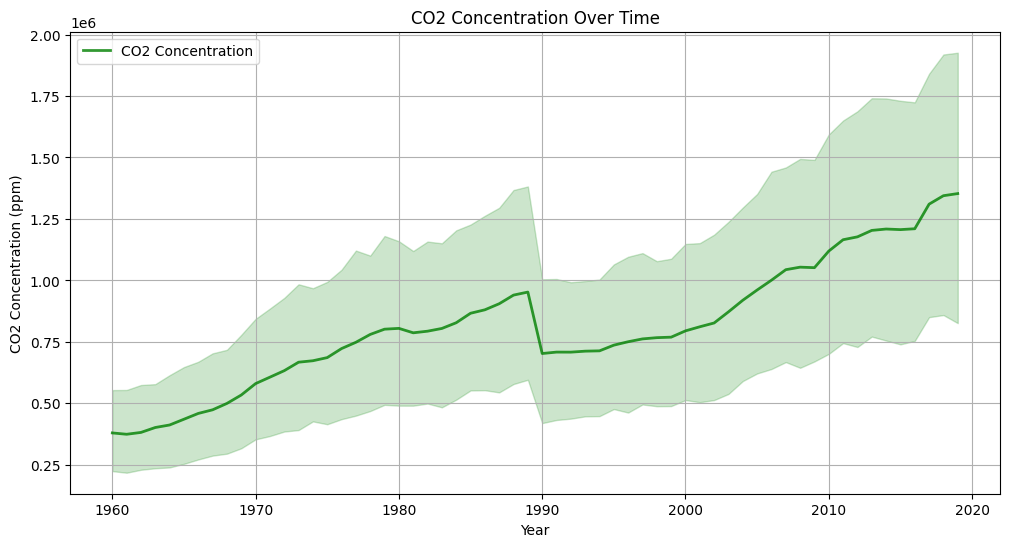

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=co2_data,
    x="year",
    y="value",
    label="CO2 Concentration",
    color="green",
    markersize=4,
    linewidth=2,
    alpha=0.8,
)
plt.title("CO2 Concentration Over Time")
plt.xlabel("Year")
plt.ylabel("CO2 Concentration (ppm)")
plt.grid()
plt.legend()
plt.savefig("./exports/co2_concentration_over_time.png")
plt.show()


This trend is a primary driver of climate change, as CO₂ is a potent greenhouse gas that traps heat in the Earth's atmosphere. The data highlights the urgency of reducing emissions to mitigate global warming.

Global temperatures have risen significantly over the past century, primarily due to human activities that increase greenhouse gas concentrations in the atmosphere. Temperature records provide the most direct evidence of climate change, revealing not only long-term warming trends but also their acceleration in recent decades.

The comparison below examines temperature anomalies between pre-industrial times (1850-1900), often used as a baseline in climate agreements like the Paris Accord, and the modern era (1970-2020). This visualization demonstrates how dramatically Earth's climate has shifted in a relatively short period from a historical perspective.

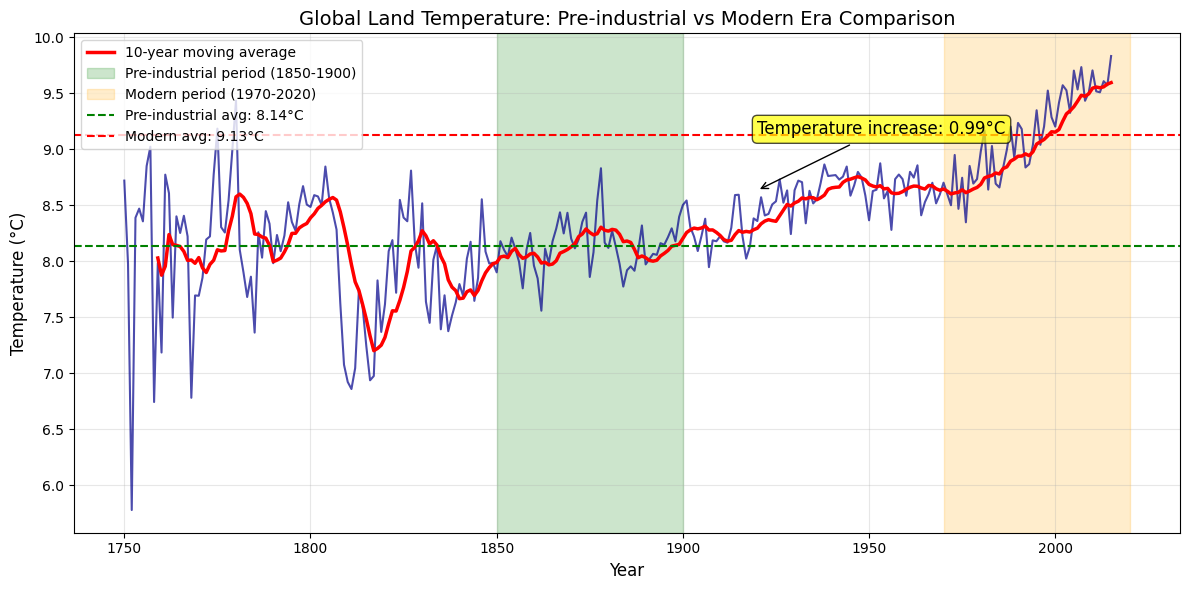

In [ ]:
plt.figure(figsize=(12, 6))

yearly_temp = (
    temperature_data.groupby("Year")["LandAverageTemperature"].mean().reset_index()
)

pre_industrial = yearly_temp[
    (yearly_temp["Year"] >= 1850) & (yearly_temp["Year"] <= 1900)
]
modern = yearly_temp[(yearly_temp["Year"] >= 1970) & (yearly_temp["Year"] <= 2020)]

pre_ind_avg = pre_industrial["LandAverageTemperature"].mean()
modern_avg = modern["LandAverageTemperature"].mean()
temp_increase = modern_avg - pre_ind_avg

sns.lineplot(
    data=yearly_temp, x="Year", y="LandAverageTemperature", color="darkblue", alpha=0.7
)

yearly_temp["10yr_moving_avg"] = (
    yearly_temp["LandAverageTemperature"].rolling(window=10).mean()
)
sns.lineplot(
    data=yearly_temp,
    x="Year",
    y="10yr_moving_avg",
    color="red",
    linewidth=2.5,
    label="10-year moving average",
)

plt.axvspan(
    1850, 1900, alpha=0.2, color="green", label="Pre-industrial period (1850-1900)"
)
plt.axvspan(1970, 2020, alpha=0.2, color="orange", label="Modern period (1970-2020)")

plt.axhline(
    y=pre_ind_avg,
    color="green",
    linestyle="--",
    label=f"Pre-industrial avg: {pre_ind_avg:.2f}°C",
)
plt.axhline(
    y=modern_avg, color="red", linestyle="--", label=f"Modern avg: {modern_avg:.2f}°C"
)

plt.annotate(
    f"Temperature increase: {temp_increase:.2f}°C",
    xy=(1920, (pre_ind_avg + modern_avg) / 2),
    xytext=(1920, (pre_ind_avg + modern_avg) / 2 + 0.5),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="black"),
    bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.7),
    fontsize=12,
)

plt.title(
    "Global Land Temperature: Pre-industrial vs Modern Era Comparison", fontsize=14
)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left")

plt.tight_layout()
plt.savefig("./exports/temperature_comparison.png")
plt.show()

del yearly_temp, pre_industrial, modern, pre_ind_avg, modern_avg, temp_increase


The relationship between atmospheric carbon dioxide (CO₂) levels and global temperatures is one of the most critical connections in climate science. As we've seen, CO₂ concentration has been steadily rising due to human activities. This increase directly impacts global temperatures through the enhanced greenhouse effect.

Carbon dioxide is a greenhouse gas that traps heat in the Earth's atmosphere. As CO₂ levels rise, more heat is retained, leading to increasing global temperatures. This relationship forms the foundation of anthropogenic climate change theory and is supported by extensive historical data.

The visualization below examines the correlation between these two key climate indicators, highlighting how closely temperature anomalies track with atmospheric CO₂ concentrations over time. This relationship is not merely coincidental—it represents a causal link that climate scientists have documented extensively through both observational data and climate models.

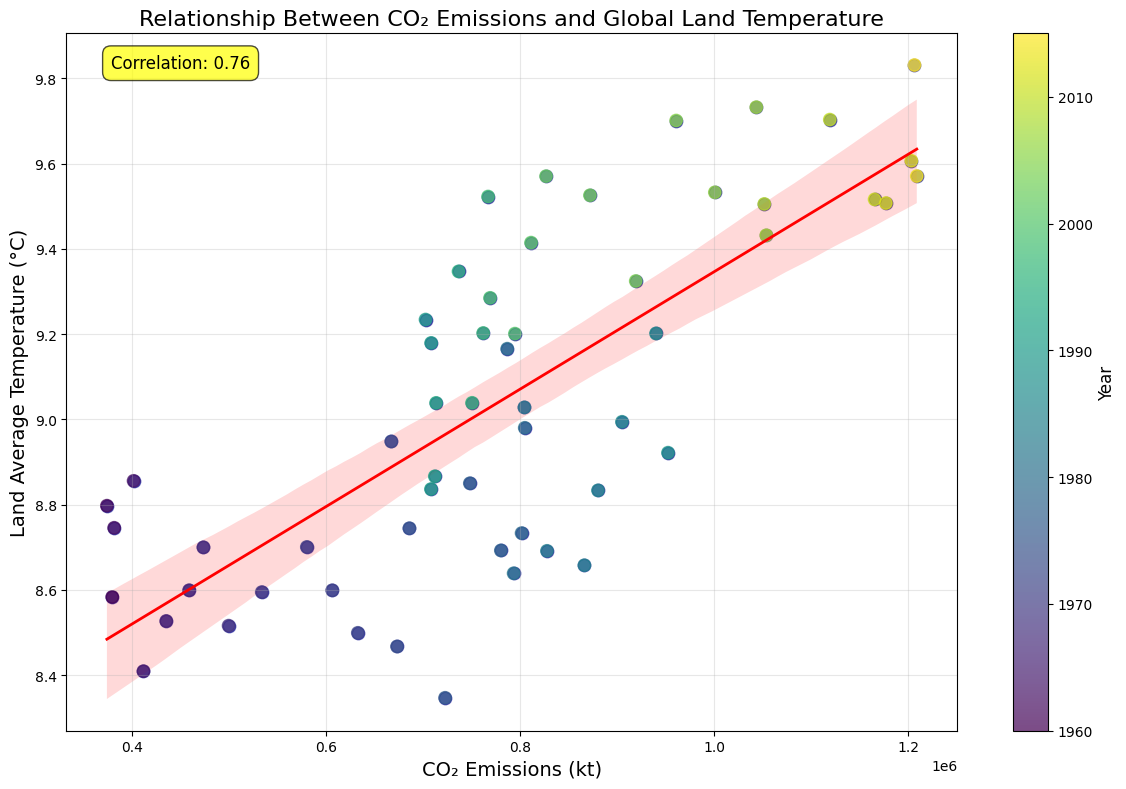

In [28]:
plt.figure(figsize=(12, 8))

yearly_temp = (
    temperature_data.groupby("Year")["LandAverageTemperature"].mean().reset_index()
)

min_year = max(yearly_temp["Year"].min(), co2_data["year"].min())
max_year = min(yearly_temp["Year"].max(), co2_data["year"].max())

yearly_temp = yearly_temp[
    (yearly_temp["Year"] >= min_year) & (yearly_temp["Year"] <= max_year)
]
yearly_temp.rename(columns={"Year": "year"}, inplace=True)

global_co2 = co2_data.groupby("year")["value"].mean().reset_index()
global_co2 = global_co2[
    (global_co2["year"] >= min_year) & (global_co2["year"] <= max_year)
]

climate_data = pd.merge(yearly_temp, global_co2, on="year", how="inner")

sns.regplot(
    x="value",
    y="LandAverageTemperature",
    data=climate_data,
    scatter_kws={"alpha": 0.6, "s": 80, "color": "darkblue"},
    line_kws={"color": "red", "linewidth": 2},
    marker="o",
)

correlation = climate_data["value"].corr(climate_data["LandAverageTemperature"])

plt.annotate(
    "Correlation: {:.2f}".format(correlation),
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.7),
    fontsize=12
)

points = plt.scatter(
    climate_data["value"],
    climate_data["LandAverageTemperature"],
    c=climate_data["year"],
    cmap="viridis",
    s=80,
    alpha=0.7,
)
cbar = plt.colorbar(points)
cbar.set_label("Year", fontsize=12)

plt.title("Relationship Between CO₂ Emissions and Global Land Temperature", fontsize=16)
plt.xlabel("CO₂ Emissions (kt)", fontsize=14)
plt.ylabel("Land Average Temperature (°C)", fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("./exports/co2_temperature_scatter.png")
plt.show()


The melting of polar ice caps is one of the most visible and concerning effects of climate change. As global temperatures rise, both the Arctic and Antarctic regions experience significant ice loss, though at different rates and patterns. This melting contributes directly to sea level rise, threatening coastal communities worldwide.

Sea level rise occurs through two main mechanisms: thermal expansion (as ocean water warms, it expands) and the addition of water from melting land ice. The data shows an accelerating trend in global sea levels, with increases closely tracking the rise in atmospheric CO₂ concentrations.

The relationship between rising CO₂ levels, increasing temperatures, and sea level rise represents one of the clearest chains of evidence for human-induced climate change and its consequences for our planet.

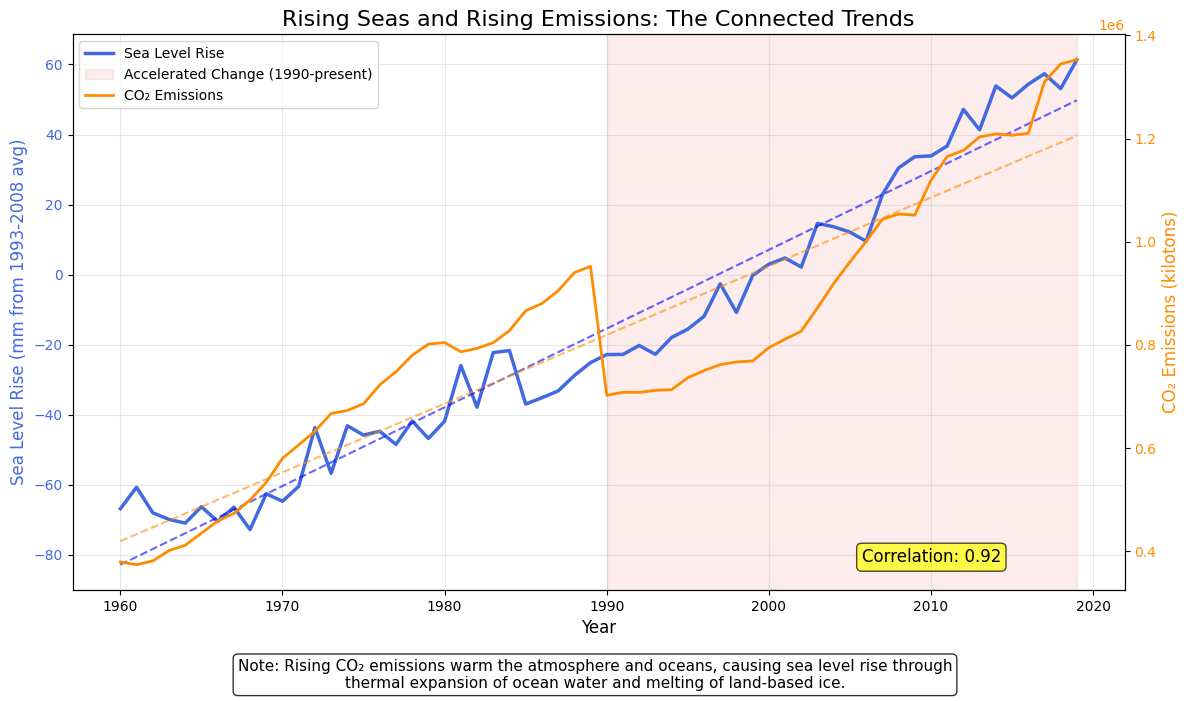

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 7))

sea_level_annual = sea_level_data.copy()
co2_annual = co2_data.groupby("year")["value"].mean().reset_index()

common_years = sorted(
    list(set(sea_level_annual["year"].unique()) & set(co2_annual["year"].unique()))
)

merged_data = pd.merge(
    sea_level_annual[sea_level_annual["year"].isin(common_years)],
    co2_annual[co2_annual["year"].isin(common_years)],
    on="year",
    how="inner",
)

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Sea Level Rise (mm from 1993-2008 avg)", color="royalblue", fontsize=12)
ax1.plot(
    merged_data["year"],
    merged_data["mmfrom1993-2008average"],
    color="royalblue",
    linewidth=2.5,
    label="Sea Level Rise",
)
ax1.tick_params(axis="y", labelcolor="royalblue")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel("CO₂ Emissions (kilotons)", color="darkorange", fontsize=12)
ax2.plot(
    merged_data["year"],
    merged_data["value"],
    color="darkorange",
    linewidth=2,
    label="CO₂ Emissions",
)
ax2.tick_params(axis="y", labelcolor="darkorange")

correlation = merged_data["mmfrom1993-2008average"].corr(merged_data["value"])

ax1.annotate(
    f"Correlation: {correlation:.2f}",
    xy=(0.75, 0.05),
    xycoords="axes fraction",
    bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.7),
    fontsize=12,
)

z_sea = np.polyfit(merged_data["year"], merged_data["mmfrom1993-2008average"], 1)
p_sea = np.poly1d(z_sea)
ax1.plot(merged_data["year"], p_sea(merged_data["year"]), "b--", alpha=0.6)

z_co2 = np.polyfit(merged_data["year"], merged_data["value"], 1)
p_co2 = np.poly1d(z_co2)
ax2.plot(
    merged_data["year"], p_co2(merged_data["year"]), "--", color="darkorange", alpha=0.6
)

recent_period = merged_data[merged_data["year"] >= 1990]
ax1.axvspan(
    1990,
    merged_data["year"].max(),
    alpha=0.15,
    color="lightcoral",
    label="Accelerated Change (1990-present)",
)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Rising Seas and Rising Emissions: The Connected Trends", fontsize=16)

plt.figtext(
    0.5,
    0.01,
    "Note: Rising CO₂ emissions warm the atmosphere and oceans, causing sea level rise through\n"
    + "thermal expansion of ocean water and melting of land-based ice.",
    ha="center",
    fontsize=11,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig("./exports/co2_sea_level_relationship.png")
plt.show()


The dual-axis overlay chart shows the relationship between sea-level rise and CO₂ concentration. The simultaneous increase in both metrics emphasizes their interconnectedness, as higher CO₂ levels contribute to global warming, which in turn causes ice to melt and sea levels to rise.

The strong correlation (0.92) between these two variables highlights one of the most direct consequences of increased greenhouse gas emissions. As atmospheric CO₂ has increased by over 200% since 1960, sea levels have risen more than 84mm from the 1993-2008 baseline period. This relationship is particularly evident in the accelerated change period after 1990, where both trends show steeper growth.

The data visualization reveals not just correlation but a causal chain: anthropogenic CO₂ emissions → atmospheric warming → thermal expansion of oceans and melting ice → sea level rise. This pattern represents one of the clearest examples of how human activities are altering Earth's systems at a planetary scale.

The Arctic ice cap is experiencing rapid decline, particularly during summer months. This visualization shows the changes in Arctic sea ice extent over time, revealing a concerning trend of ice loss. September typically marks the annual minimum ice extent in the Arctic after the summer melt season, making it a critical indicator of climate change impacts in the polar region.

The data reveals a steady and accelerating decline in sea ice coverage since satellite monitoring began in 1979, with recent decades showing the most dramatic losses. This melting has profound implications for global climate patterns, wildlife habitats, indigenous communities, and potentially opens new shipping routes through previously ice-covered waters.

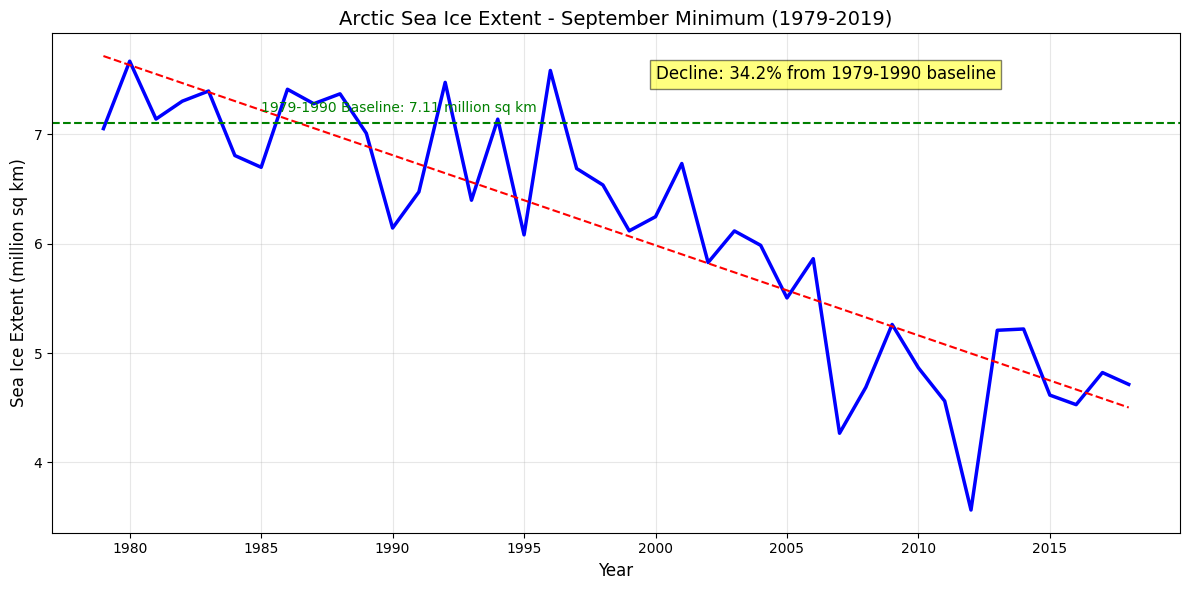

In [ ]:
arctic_annual = arctic_data.copy()

arctic_annual.rename(columns=lambda x: x.strip(), inplace=True)

arctic_annual["Date"] = pd.to_datetime(arctic_annual[["Year", "Month", "Day"]])

arctic_monthly = (
    arctic_annual.groupby([arctic_annual["Year"], arctic_annual["Month"]])["Extent"]
    .mean()
    .reset_index()
)
arctic_sept = arctic_monthly[arctic_monthly["Month"] == 9]

plt.figure(figsize=(12, 6))
plt.plot(arctic_sept["Year"], arctic_sept["Extent"], color="blue", linewidth=2.5)

z = np.polyfit(arctic_sept["Year"], arctic_sept["Extent"], 1)
p = np.poly1d(z)
plt.plot(arctic_sept["Year"], p(arctic_sept["Year"]), "r--")

plt.title("Arctic Sea Ice Extent - September Minimum (1979-2019)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Sea Ice Extent (million sq km)", fontsize=12)
plt.grid(True, alpha=0.3)

baseline = arctic_sept[arctic_sept["Year"] <= 1990]["Extent"].mean()
recent_avg = arctic_sept[arctic_sept["Year"] >= 2010]["Extent"].mean()
percent_decline = ((baseline - recent_avg) / baseline) * 100

plt.axhline(y=baseline, color="green", linestyle="--")
plt.text(
    1985,
    baseline + 0.1,
    f"1979-1990 Baseline: {baseline:.2f} million sq km",
    color="green",
)

plt.text(
    2000,
    7.5,
    f"Decline: {percent_decline:.1f}% from 1979-1990 baseline",
    bbox=dict(facecolor="yellow", alpha=0.5),
    fontsize=12,
)

plt.tight_layout()
plt.show()


This visualization shows how global precipitation patterns have changed over time and their relationship with temperature rise, illustrating the intensification of the water cycle due to climate change. As the atmosphere warms, it can hold more moisture—approximately 7% more water vapor for each degree Celsius of warming according to the Clausius-Clapeyron relationship.

This fundamental change drives several climate impacts: increased rainfall intensity during storms, longer dry periods between rainfall events, and shifting regional precipitation patterns. The data reveals not only changes in average precipitation but also increased variability, with more extreme wet and dry events becoming common as the climate system gains energy.

The correlation between rising temperatures and altered precipitation highlights one of climate change's most direct impacts on daily human experience through changing weather patterns across the globe.

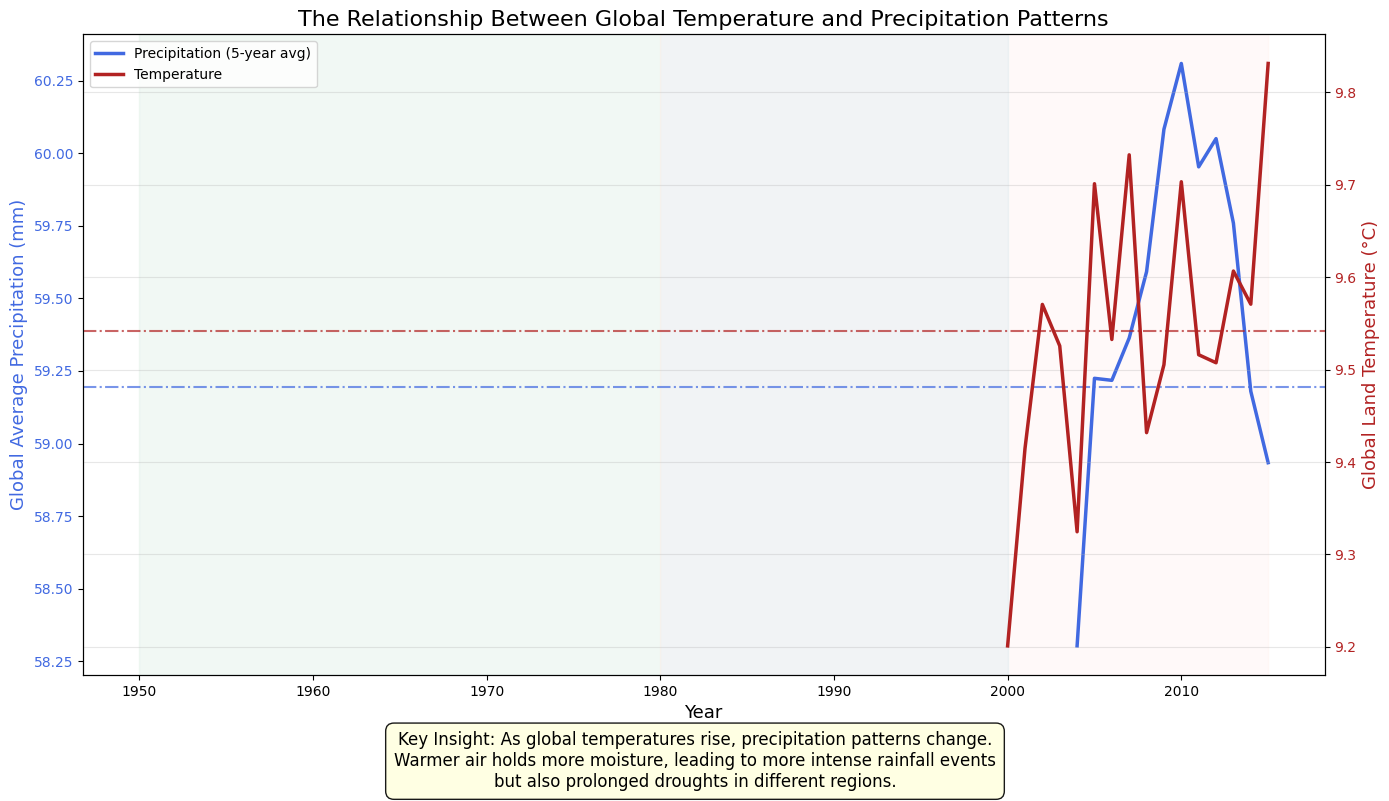

In [ ]:
precipitation_data["year"] = pd.to_datetime(
    precipitation_data["time"], unit="D", origin="1900-01-01"
).dt.year

yearly_precip = precipitation_data.groupby("year")["value"].mean().reset_index()
yearly_precip["5yr_moving_avg"] = yearly_precip["value"].rolling(window=5).mean()

yearly_temp = (
    temperature_data.groupby("Year")["LandAverageTemperature"].mean().reset_index()
)
yearly_temp.rename(columns={"Year": "year"}, inplace=True)

climate_data = pd.merge(yearly_precip, yearly_temp, on="year", how="inner")

early_period = climate_data[climate_data["year"] <= 1950]
mid_period = climate_data[
    (climate_data["year"] > 1950) & (climate_data["year"] <= 1980)
]
recent_period = climate_data[climate_data["year"] > 1980]

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel("Year", fontsize=13)
ax1.set_ylabel("Global Average Precipitation (mm)", fontsize=13, color="royalblue")
ax1.tick_params(axis="y", labelcolor="royalblue")

line1 = ax1.plot(
    climate_data["year"],
    climate_data["5yr_moving_avg"],
    color="royalblue",
    linewidth=2.5,
    label="Precipitation (5-year avg)",
)

ax1.axvspan(
    climate_data["year"].min(), 1950, alpha=0.2, color="lightblue", label="Early Period"
)
ax1.axvspan(1950, 1980, alpha=0.2, color="lightyellow", label="Mid Period")
ax1.axvspan(
    1980,
    climate_data["year"].max(),
    alpha=0.2,
    color="mistyrose",
    label="Recent Period",
)

ax2 = ax1.twinx()
ax2.set_ylabel("Global Land Temperature (°C)", fontsize=13, color="firebrick")
ax2.tick_params(axis="y", labelcolor="firebrick")

line2 = ax2.plot(
    climate_data["year"],
    climate_data["LandAverageTemperature"],
    color="firebrick",
    linewidth=2.5,
    label="Temperature",
)

early_temp_avg = early_period["LandAverageTemperature"].mean()
recent_temp_avg = recent_period["LandAverageTemperature"].mean()
early_precip_avg = early_period["value"].mean()
recent_precip_avg = recent_period["value"].mean()

early_variability = early_period["value"].std()
recent_variability = recent_period["value"].std()
variability_change = (
    (recent_variability - early_variability) / early_variability
) * 100

ax1.axhline(y=early_precip_avg, color="royalblue", linestyle="--", alpha=0.7)
ax1.axhline(y=recent_precip_avg, color="royalblue", linestyle="-.", alpha=0.7)
ax2.axhline(y=early_temp_avg, color="firebrick", linestyle="--", alpha=0.7)
ax2.axhline(y=recent_temp_avg, color="firebrick", linestyle="-.", alpha=0.7)

temp_change = recent_temp_avg - early_temp_avg
ax2.annotate(
    f"Temperature increase:\n{temp_change:.2f}°C",
    xy=(1990, (early_temp_avg + recent_temp_avg) / 2),
    xytext=(2000, (early_temp_avg + recent_temp_avg) / 2 + 0.4),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color="firebrick"),
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
    fontsize=11,
)

precip_change = ((recent_precip_avg - early_precip_avg) / early_precip_avg) * 100
ax1.annotate(
    f"Precipitation:\n{precip_change:.1f}% change in average\n{variability_change:.1f}% change in variability",
    xy=(1960, (early_precip_avg + recent_precip_avg) / 2),
    xytext=(1930, (early_precip_avg + recent_precip_avg) / 2 + 2),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2", color="royalblue"),
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
    fontsize=11,
)

wettest_year = climate_data.loc[climate_data["value"].idxmax()]["year"]
driest_year = climate_data.loc[climate_data["value"].idxmin()]["year"]

ax1.annotate(
    f"Wettest year: {int(wettest_year)}",
    xy=(
        wettest_year,
        climate_data.loc[climate_data["year"] == wettest_year, "value"].iloc[0],
    ),
    xytext=(
        wettest_year + 5,
        climate_data.loc[climate_data["year"] == wettest_year, "value"].iloc[0] + 3,
    ),
    arrowprops=dict(arrowstyle="->", color="blue"),
    fontsize=10,
)

ax1.annotate(
    f"Driest year: {int(driest_year)}",
    xy=(
        driest_year,
        climate_data.loc[climate_data["year"] == driest_year, "value"].iloc[0],
    ),
    xytext=(
        driest_year - 15,
        climate_data.loc[climate_data["year"] == driest_year, "value"].iloc[0] - 3,
    ),
    arrowprops=dict(arrowstyle="->", color="brown"),
    fontsize=10,
)

plt.figtext(
    0.5,
    0.01,
    "Key Insight: As global temperatures rise, precipitation patterns change.\n"
    + "Warmer air holds more moisture, leading to more intense rainfall events\n"
    + "but also prolonged droughts in different regions.",
    ha="center",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", alpha=0.9),
)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title(
    "The Relationship Between Global Temperature and Precipitation Patterns",
    fontsize=16,
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


## Visualizing Climate Change Relationships

The scatter matrix and correlation heatmap provide complementary views of the relationships between key climate indicators. While the correlation heatmap gives us a numerical summary of these relationships, the scatter matrix expands this analysis by:

1. Displaying the actual distribution of each variable through density plots
2. Revealing the nature of relationships (linear or non-linear)
3. Identifying potential outliers that might influence correlation values
4. Showing directionality and strength of relationships through trend lines

This multidimensional analysis helps us understand not just if variables are related, but how they're related, providing deeper insights into the complex dynamics of our changing climate system.

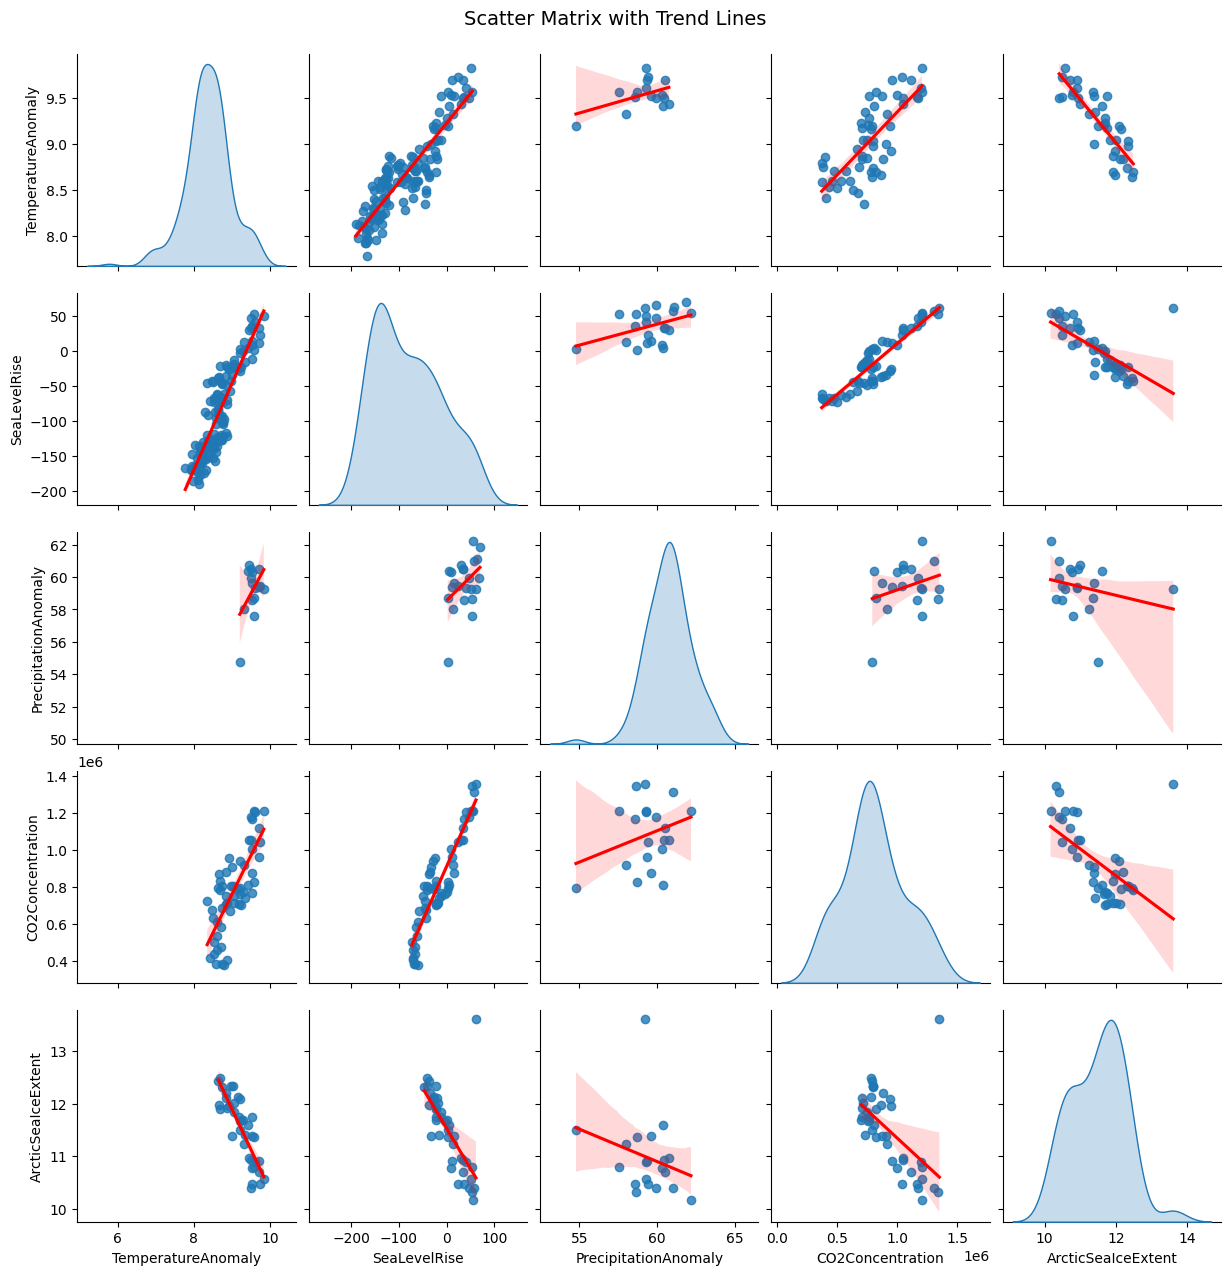

In [ ]:
# Define env_indicators
# First, ensure column names don't have leading/trailing spaces in arctic_data
arctic_data_clean = arctic_data.copy()
arctic_data_clean.columns = arctic_data_clean.columns.str.strip()

env_indicators = pd.DataFrame(
    {
        "TemperatureAnomaly": temperature_data.groupby("Year")[
            "LandAverageTemperature"
        ].mean(),
        "SeaLevelRise": sea_level_data.groupby("year")["mmfrom1993-2008average"].mean(),
        "PrecipitationAnomaly": precipitation_data.groupby("year")["value"].mean(),
        "CO2Concentration": co2_data.groupby("year")["value"].mean(),
        "ArcticSeaIceExtent": arctic_data_clean[
            arctic_data_clean["hemisphere"] == "north"
        ]
        .groupby("Year")["Extent"]
        .mean(),
    }
)

# Plot scatter matrix with trend lines
sns.pairplot(
    env_indicators, kind="reg", diag_kind="kde", plot_kws={"line_kws": {"color": "red"}}
)
plt.suptitle("Scatter Matrix with Trend Lines", fontsize=14, y=1.02)
plt.show()
